In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb

In [27]:
energy = pd.read_csv('../../data/origin/energy.csv')
us_fcst = pd.read_csv('../../data/origin/ulsan_fcst_data.csv')

In [28]:
us_fcst.head()

,Forecast time,forecast,Temperature,Humidity,WindSpeed,WindDirection,Cloud
0,2018-03-01 11:00:00,4.0,8.0,20.0,14.0,298.0,2.0
1,2018-03-01 11:00:00,7.0,4.0,20.0,4.3,298.0,2.0
2,2018-03-01 11:00:00,10.0,3.0,30.0,1.9,309.0,2.0
3,2018-03-01 11:00:00,13.0,0.0,40.0,1.5,318.0,2.0
4,2018-03-01 11:00:00,16.0,-1.0,45.0,1.8,308.0,2.0


In [36]:
# 일조량 / 일사량 데이터 조정 & 취합
# 태양광에서 중요도 일조량 < 일사량
# 일사량 (Insolation) : 태양복사에너지가 지구에 도달하는 에너지의 양
# 일조량 (Sunshine) : (시간개념) 대기중의 물질 등의 영향을 받지않고 태양에서 지구로 도달하는 빛의 양
# - 일정한 물체에 표면이나 지표면에 비치는 햇몉의 양
us_2018 = pd.read_csv('us_2018.csv', encoding='euc-kr')
us_2019 = pd.read_csv('us_2019.csv', encoding='euc-kr')
us_2020 = pd.read_csv('us_2020.csv', encoding='euc-kr')

In [37]:
# 일조/일자/지면온도 데이터만 뽑기
# us_2018 = us_2018[['일시', '일조(hr)', '일사(MJ/m2)', '지면온도(°C)']]
# us_2019 = us_2019[['일시', '일조(hr)', '일사(MJ/m2)', '지면온도(°C)']]
# us_2020 = us_2020[['일시', '일조(hr)', '일사(MJ/m2)', '지면온도(°C)']]
us_2018 = us_2018[['일시', '일조(hr)',  '지면온도(°C)']]
us_2019 = us_2019[['일시', '일조(hr)',  '지면온도(°C)']]
us_2020 = us_2020[['일시', '일조(hr)', '지면온도(°C)']]
us_2020.head()

,일시,일조(hr),지면온도(°C)
0,2020-01-01 00:00,NaN,-4.0
1,2020-01-01 01:00,NaN,-4.3
2,2020-01-01 02:00,NaN,-4.4
3,2020-01-01 03:00,NaN,-4.1
4,2020-01-01 04:00,NaN,-4.0


In [38]:
# 일시 컬럼 -> datatime 양식 맞춤
us_2018['일시'] = pd.to_datetime(us_2018['일시'])
us_2019['일시'] = pd.to_datetime(us_2019['일시'])
us_2020['일시'] = pd.to_datetime(us_2020['일시'])
us_2020.head()


,일시,일조(hr),지면온도(°C)
0,2020-01-01 00:00:00,NaN,-4.0
1,2020-01-01 01:00:00,NaN,-4.3
2,2020-01-01 02:00:00,NaN,-4.4
3,2020-01-01 03:00:00,NaN,-4.1
4,2020-01-01 04:00:00,NaN,-4.0


In [39]:
# 2018, 2019, 2020 데이터 이어붙이기
us_sunshine = pd.concat([us_2018, us_2019, us_2020])
us_sunshine.iloc[10:14]

,일시,일조(hr),지면온도(°C)
10,2018-01-01 10:00:00,1.0,-0.1
11,2018-01-01 11:00:00,1.0,1.5
12,2018-01-01 12:00:00,1.0,3.0
13,2018-01-01 13:00:00,1.0,5.0


In [41]:
# 데이터 속성 이름 변경
# us_sunshine = us_sunshine.rename(columns={us_sunshine.columns[0]:"Forecast_time", us_sunshine.columns[1]:"Sunshine",us_sunshine.columns[2]:"Insolation",us_sunshine.columns[3]:"Ground temperature"})
us_sunshine = us_sunshine.rename(columns={us_sunshine.columns[0]:"Forecast_time", us_sunshine.columns[1]:"Sunshine",us_sunshine.columns[2]:"Ground temperature"})
us_sunshine.head()

,Forecast_time,Sunshine,Ground temperature
0,2018-01-01 00:00:00,NaN,-1.1
1,2018-01-01 01:00:00,NaN,-1.2
2,2018-01-01 02:00:00,NaN,-1.4
3,2018-01-01 03:00:00,NaN,-1.5
4,2018-01-01 04:00:00,NaN,-1.7


In [42]:
us_tmp = us_fcst
us_tmp['Forecast_time'] = pd.to_datetime(us_tmp['Forecast time'])
us_tmp_14 = us_tmp[us_tmp['Forecast_time'].dt.hour==14]
us_tmp_14 = us_tmp_14[(us_tmp_14['forecast']>=10)&(us_tmp_14['forecast']<=33)]
def to_date(x):
    return pd.DateOffset(hours=x)

us_tmp_14['Forecast_time'] = us_tmp_14['Forecast_time'] + us_tmp_14['forecast'].map(to_date)
us_tmp_14 = us_tmp_14[['Forecast_time', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud']]
us_tmp_14_ = pd.DataFrame()
us_tmp_14_['Forecast_time'] = pd.date_range(start='2018-03-02 00:00:00', end='2021-03-01 23:00:00', freq='H')
us_tmp_14_ = pd.merge(us_tmp_14_, us_tmp_14, on='Forecast_time', how='outer')
us_tmp_14_.head()


D:\anaconda3\lib\site-packages\pandas\core\arrays\datetimelike.py:1342: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized
  warnings.warn(


,Forecast_time,Temperature,Humidity,WindSpeed,WindDirection,Cloud
0,2018-03-02 00:00:00,0.0,40.0,1.5,318.0,2.0
1,2018-03-02 01:00:00,NaN,NaN,NaN,NaN,NaN
2,2018-03-02 02:00:00,NaN,NaN,NaN,NaN,NaN
3,2018-03-02 03:00:00,-1.0,45.0,1.8,308.0,2.0
4,2018-03-02 04:00:00,NaN,NaN,NaN,NaN,NaN


In [43]:
us_tmp_14_ = pd.merge(us_tmp_14_, us_sunshine, how='left', left_on='Forecast_time', right_on='Forecast_time')
us_tmp_14_.iloc[10:14]


,Forecast_time,Temperature,Humidity,WindSpeed,WindDirection,Cloud,Sunshine,Ground temperature
10,2018-03-02 10:00:00,NaN,NaN,NaN,NaN,NaN,1.0,0.3
11,2018-03-02 11:00:00,NaN,NaN,NaN,NaN,NaN,1.0,6.1
12,2018-03-02 12:00:00,6.0,30.0,1.4,324.0,1.0,1.0,11.8
13,2018-03-02 13:00:00,NaN,NaN,NaN,NaN,NaN,1.0,14.5


In [44]:
us_tmp = us_tmp_14_.interpolate()
us_tmp.iloc[10:14]

,Forecast_time,Temperature,Humidity,WindSpeed,WindDirection,Cloud,Sunshine,Ground temperature
10,2018-03-02 10:00:00,2.0,33.333333,1.733333,322.000000,1.0,1.0,0.3
11,2018-03-02 11:00:00,4.0,31.666667,1.566667,323.000000,1.0,1.0,6.1
12,2018-03-02 12:00:00,6.0,30.000000,1.400000,324.000000,1.0,1.0,11.8
13,2018-03-02 13:00:00,7.0,30.000000,1.200000,229.333333,1.0,1.0,14.5


In [45]:
us_tmp['Forecast_time'] = us_tmp['Forecast_time'].astype(str)
us_tmp.head()

,Forecast_time,Temperature,Humidity,WindSpeed,WindDirection,Cloud,Sunshine,Ground temperature
0,2018-03-02 00:00:00,0.000000,40.000000,1.500000,318.000000,2.000000,NaN,-0.1
1,2018-03-02 01:00:00,-0.333333,41.666667,1.600000,314.666667,2.000000,NaN,-0.2
2,2018-03-02 02:00:00,-0.666667,43.333333,1.700000,311.333333,2.000000,NaN,-0.3
3,2018-03-02 03:00:00,-1.000000,45.000000,1.800000,308.000000,2.000000,NaN,-0.5
4,2018-03-02 04:00:00,-1.333333,45.000000,1.766667,303.333333,1.666667,NaN,-0.7


In [ ]:
# 그래프 분석

In [73]:
us_fcst['Forecast_time'] = pd.to_datetime(us_fcst['Forecast time'])
us_fcst.head()

,Forecast time,forecast,Temperature,Humidity,WindSpeed,WindDirection,Cloud,Forecast_time
0,2018-03-01 11:00:00,4.0,8.0,20.0,14.0,298.0,2.0,2018-03-01 11:00:00
1,2018-03-01 11:00:00,7.0,4.0,20.0,4.3,298.0,2.0,2018-03-01 11:00:00
2,2018-03-01 11:00:00,10.0,3.0,30.0,1.9,309.0,2.0,2018-03-01 11:00:00
3,2018-03-01 11:00:00,13.0,0.0,40.0,1.5,318.0,2.0,2018-03-01 11:00:00
4,2018-03-01 11:00:00,16.0,-1.0,45.0,1.8,308.0,2.0,2018-03-01 11:00:00


In [74]:
us_fcst_14 = us_fcst[us_fcst['Forecast_time'].dt.hour==14]
us_fcst_14.head()

,Forecast time,forecast,Temperature,Humidity,WindSpeed,WindDirection,Cloud,Forecast_time
20,2018-03-01 14:00:00,4.0,4.0,20.0,4.3,298.0,2.0,2018-03-01 14:00:00
21,2018-03-01 14:00:00,7.0,3.0,30.0,1.9,309.0,2.0,2018-03-01 14:00:00
22,2018-03-01 14:00:00,10.0,0.0,40.0,1.5,318.0,2.0,2018-03-01 14:00:00
23,2018-03-01 14:00:00,13.0,-1.0,45.0,1.8,308.0,2.0,2018-03-01 14:00:00
24,2018-03-01 14:00:00,16.0,-2.0,45.0,1.7,294.0,1.0,2018-03-01 14:00:00


In [75]:
us_fcst_14 = us_fcst_14[(us_fcst_14['forecast']>=10)&(us_fcst_14['forecast']<=33)]
us_fcst_14.head()

,Forecast time,forecast,Temperature,Humidity,WindSpeed,WindDirection,Cloud,Forecast_time
22,2018-03-01 14:00:00,10.0,0.0,40.0,1.5,318.0,2.0,2018-03-01 14:00:00
23,2018-03-01 14:00:00,13.0,-1.0,45.0,1.8,308.0,2.0,2018-03-01 14:00:00
24,2018-03-01 14:00:00,16.0,-2.0,45.0,1.7,294.0,1.0,2018-03-01 14:00:00
25,2018-03-01 14:00:00,19.0,0.0,35.0,1.9,321.0,1.0,2018-03-01 14:00:00
26,2018-03-01 14:00:00,22.0,6.0,30.0,1.4,324.0,1.0,2018-03-01 14:00:00


In [76]:
def to_date(x):
    return pd.DateOffset(hours=x)

us_fcst_14['Forecast_time'] = us_fcst_14['Forecast_time'] + us_fcst_14['forecast'].map(to_date)
us_fcst_14.head()

D:\anaconda3\lib\site-packages\pandas\core\arrays\datetimelike.py:1342: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized
  warnings.warn(


,Forecast time,forecast,Temperature,Humidity,WindSpeed,WindDirection,Cloud,Forecast_time
22,2018-03-01 14:00:00,10.0,0.0,40.0,1.5,318.0,2.0,2018-03-02 00:00:00
23,2018-03-01 14:00:00,13.0,-1.0,45.0,1.8,308.0,2.0,2018-03-02 03:00:00
24,2018-03-01 14:00:00,16.0,-2.0,45.0,1.7,294.0,1.0,2018-03-02 06:00:00
25,2018-03-01 14:00:00,19.0,0.0,35.0,1.9,321.0,1.0,2018-03-02 09:00:00
26,2018-03-01 14:00:00,22.0,6.0,30.0,1.4,324.0,1.0,2018-03-02 12:00:00


In [77]:
# us_fcst_14 = us_fcst_14[['Forecast_time', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud', 'Sunshine', 'Insolatio//, 'Ground temperature']]
us_fcst_14 = us_fcst_14[['Forecast_time', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud']]
us_fcst_14.head()

,Forecast_time,Temperature,Humidity,WindSpeed,WindDirection,Cloud
22,2018-03-02 00:00:00,0.0,40.0,1.5,318.0,2.0
23,2018-03-02 03:00:00,-1.0,45.0,1.8,308.0,2.0
24,2018-03-02 06:00:00,-2.0,45.0,1.7,294.0,1.0
25,2018-03-02 09:00:00,0.0,35.0,1.9,321.0,1.0
26,2018-03-02 12:00:00,6.0,30.0,1.4,324.0,1.0


In [78]:
us_fcst_14_ = pd.DataFrame()
us_fcst_14_['Forecast_time'] = pd.date_range(start='2018-03-02 00:00:00', end='2021-03-01 23:00:00', freq='H')
us_fcst_14_.head()

,Forecast_time
0,2018-03-02 00:00:00
1,2018-03-02 01:00:00
2,2018-03-02 02:00:00
3,2018-03-02 03:00:00
4,2018-03-02 04:00:00


In [79]:
us_fcst_14_ = pd.merge(us_fcst_14_, us_fcst_14, on='Forecast_time', how='outer')
us_fcst_14_.head()

,Forecast_time,Temperature,Humidity,WindSpeed,WindDirection,Cloud
0,2018-03-02 00:00:00,0.0,40.0,1.5,318.0,2.0
1,2018-03-02 01:00:00,NaN,NaN,NaN,NaN,NaN
2,2018-03-02 02:00:00,NaN,NaN,NaN,NaN,NaN
3,2018-03-02 03:00:00,-1.0,45.0,1.8,308.0,2.0
4,2018-03-02 04:00:00,NaN,NaN,NaN,NaN,NaN


In [48]:
# us_fcst = us_fcst_14_.interpolate()
# us_fcst.head()
us_tmp = us_fcst_14_.interpolate()
us_fcst.head()

,Forecast_time,Temperature,Humidity,WindSpeed,WindDirection,Cloud
0,2018-03-02 00:00:00,0.000000,40.000000,1.500000,318.000000,2.000000
1,2018-03-02 01:00:00,-0.333333,41.666667,1.600000,314.666667,2.000000
2,2018-03-02 02:00:00,-0.666667,43.333333,1.700000,311.333333,2.000000
3,2018-03-02 03:00:00,-1.000000,45.000000,1.800000,308.000000,2.000000
4,2018-03-02 04:00:00,-1.333333,45.000000,1.766667,303.333333,1.666667


In [49]:
us_fcst['Forecast_time'] = us_fcst['Forecast_time'].astype(str)
us_fcst.head()


,Forecast_time,Temperature,Humidity,WindSpeed,WindDirection,Cloud
0,2018-03-02 00:00:00,0.000000,40.000000,1.500000,318.000000,2.000000
1,2018-03-02 01:00:00,-0.333333,41.666667,1.600000,314.666667,2.000000
2,2018-03-02 02:00:00,-0.666667,43.333333,1.700000,311.333333,2.000000
3,2018-03-02 03:00:00,-1.000000,45.000000,1.800000,308.000000,2.000000
4,2018-03-02 04:00:00,-1.333333,45.000000,1.766667,303.333333,1.666667


In [46]:
def train_datast(energy_df, fcst_df, target):
    # 일기 예보 있는 날짜만 선택
    energy = energy_df.loc[24:]
    energy.index = range(energy.shape[0])
    
    # 발전량 데이터가 있는 날짜만 선택
    fcst = fcst_df.loc[:25608-1]
    fcst.index = range(fcst.shape[0])
    
    # 발전량과 일기예보 연결
    concat_df = pd.concat([energy, fcst], axis=1)
    
    # 예보 시간 및 날짜 정보 feature로 추가
    concat_df['date'] = concat_df['Forecast_time'].str.split(' ').str[0]
    concat_df['hour'] = concat_df['Forecast_time'].str.split(' ').str[1].str.split(':').str[0].astype(int)
    
    concat_df['year'] = concat_df['date'].str.split('-').str[0].astype(int)
    concat_df['month'] = concat_df['date'].str.split('-').str[1].astype(int)
    concat_df['day'] = concat_df['date'].str.split('-').str[2].astype(int)
    
    # 예보 시간, 날짜, 기상 예보 및 발전량 선택
    feature_df = concat_df[['year', 'month', 'day', 'hour', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud', target]]
    
    # 마지막 30일을 검증데이터셋으로 나머지를 학습 데이터셋으로 선택
    train_df = feature_df.iloc[:-24*30]
    val_df = feature_df.iloc[-24*30:]
    
    # 발전량이 0인 데이터를 제외
    train_df = train_df[train_df[target]!=0]
    
    train_x = train_df.loc[:, 'year':'Cloud'].to_numpy()
    train_y = train_df[target].to_numpy()
    
    val_x = val_df.loc[:, 'year':'Cloud'].to_numpy()
    val_y = val_df[target].to_numpy()
    
    return train_x, train_y, val_x, val_y

In [52]:
def nmae_10(y_pred, dataset):
    y_true = dataset.get_label()
    
    absolute_error = abs(y_true - y_pred)
    absolute_error /= capacity
    
    target_idx = np.where(y_true>=capacity*0.1)
    
    nmae = 100 * absolute_error[target_idx].mean()
    
    return 'score', nmae, False

In [51]:
def sola_nmae(answer, pred):
    absolute_error = np.abs(answer - pred)
    
    absolute_error /= capacity
    
    target_idx = np.where(answer>=capacity*0.1)
    
    nmae = 100 * absolute_error[target_idx].mean()
    
    return nmae

In [53]:
params = {
    'learning_rate': 0.01,
    'objective': 'regression',
    'metric':'mae',
    'seed':42
}

In [93]:
train_x, train_y, val_x, val_y = train_datast(energy, us_fcst, target='ulsan')
train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)
capacity = 500
ulsan_model = lgb.train(params, train_dataset, 10000, val_dataset, feval=nmae_10, verbose_eval=500, early_stopping_rounds=100)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003147 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 752
[LightGBM] [Info] Number of data points in the train set: 11811, number of used features: 9
[LightGBM] [Info] Start training from score 135.559394
Training until validation scores don't improve for 100 rounds
[500]	valid_0's l1: 17.2554	valid_0's score: 6.35312
Early stopping, best iteration is:
[648]	valid_0's l1: 14.5273	valid_0's score: 6.32597


In [25]:
train_x, train_y, val_x, val_y = train_datast(energy, us_fcst, target='ulsan')
train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)
capacity = 500
ulsan_model = lgb.train(params, train_dataset, 10000, val_dataset, feval=nmae_10, verbose_eval=500, early_stopping_rounds=100)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 752
[LightGBM] [Info] Number of data points in the train set: 11811, number of used features: 9
[LightGBM] [Info] Start training from score 135.559394
Training until validation scores don't improve for 100 rounds
[500]	valid_0's l1: 17.2554	valid_0's score: 6.35312
Early stopping, best iteration is:
[648]	valid_0's l1: 14.5273	valid_0's score: 6.32597


In [54]:
# 일조량/일사량
train_x, train_y, val_x, val_y = train_datast(energy, us_tmp, target='ulsan')
train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)
capacity = 500
ulsan_model = lgb.train(params, train_dataset, 10000, val_dataset, feval=nmae_10, verbose_eval=500, early_stopping_rounds=100)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000439 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 752
[LightGBM] [Info] Number of data points in the train set: 11811, number of used features: 9
[LightGBM] [Info] Start training from score 135.559394
Training until validation scores don't improve for 100 rounds
[500]	valid_0's l1: 17.2554	valid_0's score: 6.35312
Early stopping, best iteration is:
[648]	valid_0's l1: 14.5273	valid_0's score: 6.32597


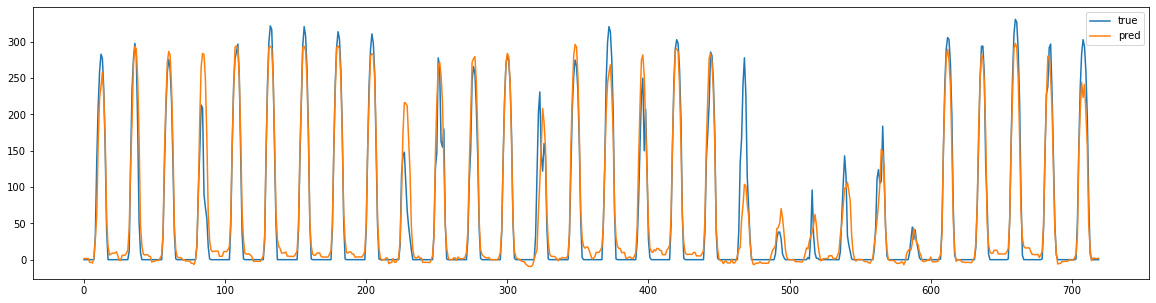

CV Score :  6.32596666174072


In [94]:
pred = ulsan_model.predict(val_x)

plt.figure(figsize=(20,5))
plt.plot(val_y, label='true')
plt.plot(pred, label='pred')
plt.legend()
plt.show()
print('CV Score : ', sola_nmae(val_y, pred))

In [95]:
def test_datast(fcst_df):
    start = '2021-02-01 00:00:00'
    end = '2021-02-28 23:00:00'
    
    start_idx = fcst_df[fcst_df['Forecast_time']==start].index[0]
    end_idx = fcst_df[fcst_df['Forecast_time']==end].index[0]
    
    test_df = fcst_df.loc[start_idx:end_idx, :].copy()
    
    test_df['date'] = test_df['Forecast_time'].str.split(' ').str[0]
    test_df['hour'] = test_df['Forecast_time'].str.split(' ').str[1].str.split(':').str[0].astype(int)
    
    test_df['year'] = test_df['date'].str.split('-').str[0].astype(int)
    test_df['month'] = test_df['date'].str.split('-').str[1].astype(int)
    test_df['day'] = test_df['date'].str.split('-').str[2].astype(int)
    
    test_df = test_df[['year', 'month', 'day', 'hour', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud']]
    
    test_x = test_df.to_numpy()
    
    return test_x

In [57]:
dangjin_test = test_datast(dj_fcst)
ulsan_test = test_datast(us_fcst)

In [59]:
dangjin_floating_pred = dangjin_floating_model.predict(dangjin_test)
dangjin_warehouse_pred = dangjin_warehouse_model.predict(dangjin_test)
dangjin_pred = dangjin_model.predict(dangjin_test)
ulsan_pred = ulsan_model.predict(ulsan_test)

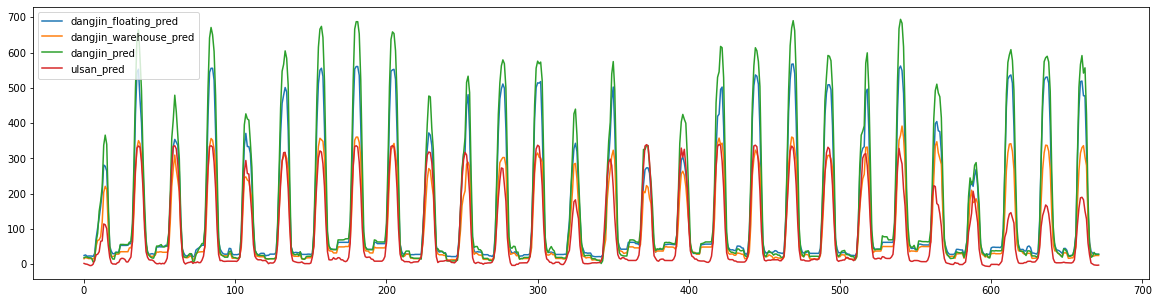

In [60]:
plt.figure(figsize=(20,5))
plt.plot(dangjin_floating_pred, label = 'dangjin_floating_pred')
plt.plot(dangjin_warehouse_pred, label = 'dangjin_warehouse_pred')
plt.plot(dangjin_pred, label = 'dangjin_pred')
plt.plot(ulsan_pred, label = 'ulsan_pred')
plt.legend()
plt.show()

In [61]:
submission = pd.read_csv('data/sample_submission.csv')
submission.head()

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
0,2021-02-01 01:00:00,0,0,0,0
1,2021-02-01 02:00:00,0,0,0,0
2,2021-02-01 03:00:00,0,0,0,0
3,2021-02-01 04:00:00,0,0,0,0
4,2021-02-01 05:00:00,0,0,0,0


In [62]:
submission.iloc[:24*28, 1] = dangjin_floating_pred
submission.iloc[:24*28, 2] = dangjin_warehouse_pred
submission.iloc[:24*28, 3] = dangjin_pred
submission.iloc[:24*28, 4] = ulsan_pred

In [63]:
submission

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
0,2021-02-01 01:00:00,24.483832,15.214285,18.105945,1.873168
1,2021-02-01 02:00:00,25.977351,18.773044,20.342899,0.174000
2,2021-02-01 03:00:00,22.270540,17.017413,20.039962,-0.375374
3,2021-02-01 04:00:00,22.867442,15.654681,17.890137,-2.402164
4,2021-02-01 05:00:00,22.867442,15.654681,17.890137,-4.250874
...,...,...,...,...,...
1387,2021-07-08 20:00:00,0.000000,0.000000,0.000000,0.000000
1388,2021-07-08 21:00:00,0.000000,0.000000,0.000000,0.000000
1389,2021-07-08 22:00:00,0.000000,0.000000,0.000000,0.000000
1390,2021-07-08 23:00:00,0.000000,0.000000,0.000000,0.000000


In [64]:
submission.to_csv('dacon_baseline.csv', index=False)